# Introduction to Transaction Costs in Backtesting
The realism and effectiveness of backtesting largely hinge on accurately accounting for transaction costs. These costs can significantly impact the profitability and viability of a trading strategy. Note that if you want an ultra realistic backtest - the closest you can get is an event driven engine, a vectorised backtest will only give us a heuristic measure, which is good enough for 90% of professional traders. 

There are three primary types of transaction costs that traders need to consider in a backtest:

1. **Commissions**
Commissions are fees levied by brokers for executing trades. They can vary widely based on the broker's pricing structure, the asset class, and the volume of the trade. Commissions can either be a fixed fee per trade, a percentage of the trade value, or based on the number of shares or contracts traded.

* **Best Practices**
    * Broker-Specific Calculation: Ensure that the commission structure in your backtest mirrors the structure of the broker you plan to use for live trading.
    * Tiered Structures: If your broker uses a tiered commission structure, make sure your backtest accounts for varying rates at different volume thresholds.
    * Impact on Strategy: Pay attention to strategies involving frequent trades, such as day trading or high-frequency trading, where commission costs can quickly accumulate and significantly impact net returns.

2. **Bid-Ask Spread**
The bid-ask spread is the difference between the highest price a buyer is willing to pay (bid) and the lowest price a seller is willing to accept (ask). This spread is a cost to traders, and it's particularly relevant for assets with lower liquidity, where spreads can be wider.

* **Best Practices**

    * Historical Spreads: Utilize historical spread data to estimate average spreads for the assets in your strategy.
    * Intraday Trading: For intraday trading strategies, consider using intraday spread data, as spreads can vary significantly throughout the trading day.
    * Asset Liquidity: Be mindful of asset liquidity, as illiquid assets often have wider spreads, which can erode profits, especially in large trades.

3. **Market Impact**
Market impact refers to the effect that a trader's orders have on the market price of an asset. Particularly with large orders, a trader’s activity can shift the market price, leading to slippage – the difference between the expected price of a trade and the price at which the trade is actually executed.

* **Best Practices**

    * Size Matters: The larger the order relative to the market volume, the greater the potential market impact. Factor this into strategies involving large trades.
    * Modeling Market Impact: Utilize market impact models, like the linear cost model - or the square root model, which proposes that the impact is proportional to the square root of the order size.
    * Adaptive Strategies: Consider strategies that minimize market impact, such as breaking up large orders into smaller ones or using algorithmic execution strategies that adapt to market conditions.
    
## Extra Costs:
If you want to go even further, you can add (**Note**: I don't know many people who added these in a vectorised setting):
* Borrowing costs for short selling.
* Swap Rates and Financing Costs for Forex.

---

## Replicate the Momentum Strategy

Below we replicate the volatility targeted momentum strategy that we built in the previous tutorial.

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import quantstats as qs

import matplotlib.pyplot as plt

## Fetching SPX Adj Close Price Data from Yahoo Finance

In [3]:
# Downloading S&P 500 index data from Yahoo Finance
spx = yf.download('SPY', start='2000-01-01', end='2023-01-01')

# Extracting the closing prices
close_prices = spx['Close']
volume = spx['Volume']

[*********************100%%**********************]  1 of 1 completed


##### Visualizing S&P 500 Closing Prices
Visual representation of data is vital for a better understanding of market trends. Here, we plot the closing prices of the S&P 500 Index.

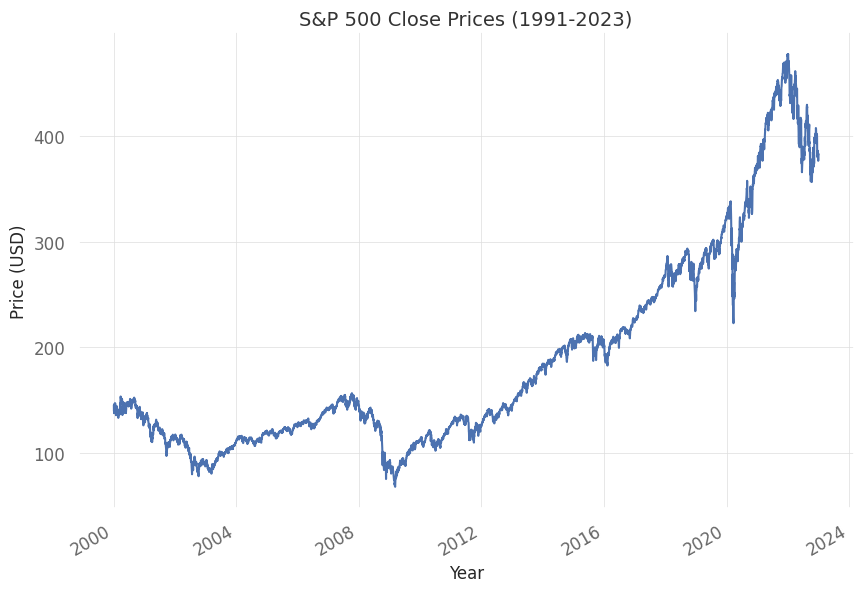

In [4]:
# Plotting the S&P 500 closing prices
close_prices.plot(figsize=(10, 7), linewidth=1.5)
plt.title('S&P 500 Close Prices (1991-2023)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(True)
plt.show()

### Moving Average Crossover Strategy from Previous Tutorial

In [5]:
# Calculating Moving Averages (Indicators)
short_window = 50
long_window = 252

short_ma = close_prices.rolling(window=short_window, min_periods=short_window).mean()
long_ma = close_prices.rolling(window=long_window, min_periods=long_window).mean()

In [6]:
# Generating Trading Signals
signals = pd.DataFrame(index=close_prices.index)
signals['signal'] = 0.0  # Set the default to be 0
signals['short_ma'] = short_ma
signals['long_ma'] = long_ma

# When the short is above the long, buy - else go short sell.
# Note that our signal is just a simple buy or sell, -1 or 1.
signals['signal'][signals['short_ma'] > signals['long_ma']] = 1
signals['signal'][signals['short_ma'] < signals['long_ma']] = -1

In [7]:
# Set the target volatility level
tgt_vol = 0.15

# Calculate daily percentage returns of SPX
spx_returns = close_prices.pct_change()

# Calculate the rolling annual standard deviation of SPX returns
signals['stdev'] = spx_returns.rolling(22).std() * np.sqrt(252)  # Convert to annualized standard deviation

# Calculate volatility target weights
signals['vol_tgt'] = tgt_vol / signals['stdev']

# Clip weights to a maximum of 1 to avoid leverage
# Here we use 2x leverage to make sure we can hit our volatility target of 15%
signals['vol_tgt'] = signals['vol_tgt'].clip(0, 2)

In [8]:
# Adjust the signal by the volatility target, lagging both to avoid look-ahead bias
vol_signal = signals['signal'].shift(1) * signals['vol_tgt'].shift(1)

# Compute returns for the volatility-targeted strategy
strategy_voltgt_returns = spx_returns * vol_signal

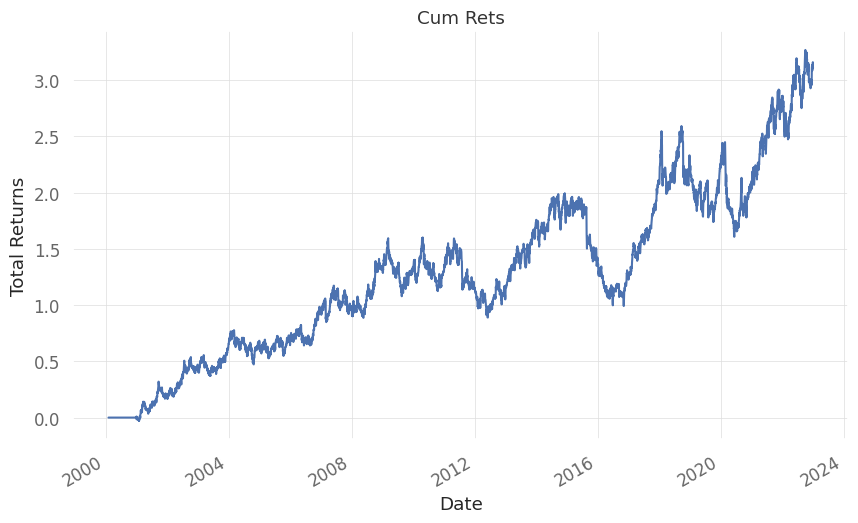

In [9]:
# Plot the cumulative rets (compounded growth)
((strategy_voltgt_returns + 1).cumprod()-1).plot(title='Cum Rets')
plt.ylabel('Total Returns')
plt.show()

---

## Computing Turnover to Calculate Transaction Costs

Since transaction costs arise primarily through trading activities, it's pivotal to focus on turnover to gauge these expenses effectively. Turnover, in this context, refers to the frequency and volume of trades within a portfolio.

Recall how we implemented volatility targeting to determine the percentage of our portfolio to be allocated at any given time? Turnover takes this a step further by measuring the daily fluctuation in our positions. Essentially, it's the rate at which securities are replaced or "turned over" in the portfolio. This metric is calculated as the absolute difference in our position sizes from one day to the next, providing a clear picture of how frequently and significantly we adjust our holdings. Understanding and calculating turnover is crucial as it directly correlates with the frequency of incurred transaction costs, thereby impacting the overall performance of the trading strategy.

**Note:**
* Shift the turnover by -1 becuase the vol_signal is the position we held at time t, and we need to know the date when the transaction occurred, which was the day before.

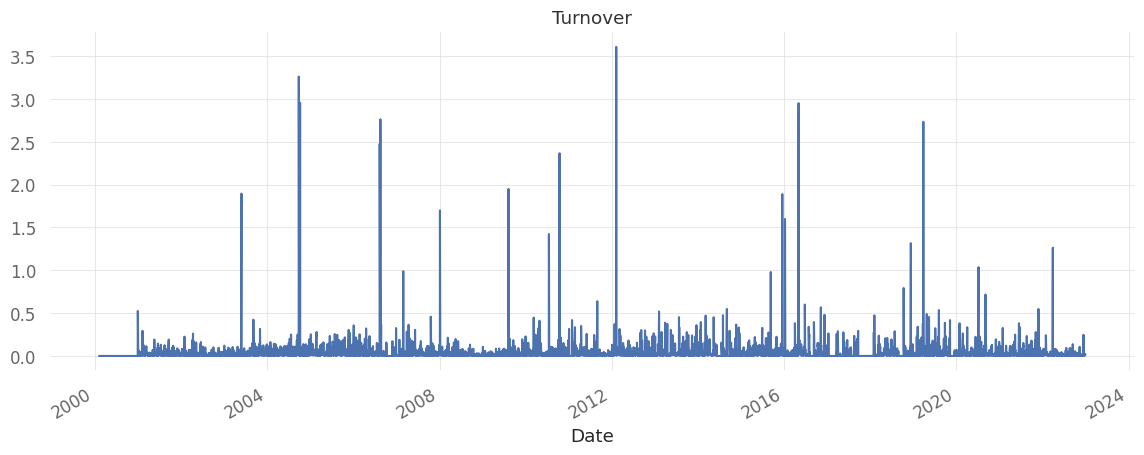

In [11]:
turnover = abs(vol_signal.diff())

# Shift by -1 to get the date at which the transaction occurred, which was at close yesterday.
turnover = turnover.shift(-1)

# Plot Turnover
turnover.plot(title='Turnover', figsize=(14, 5))
plt.show()

---
## Incorporating Brokerage Fees in Backtesting

Brokerage fees, a crucial factor in the profitability of trading strategies, vary widely among brokers and are typically measured in basis points. A basis point is a unit of measure used in finance to describe the percentage change in the value or rate of a financial instrument. One basis point is equivalent to 0.01% (1/100th of a percent) or 0.0001 in decimal form. For instance, if a broker charges 10 basis points as a commission, it means they are charging 0.10% of the trade value.

During my early career at a hedge fund, we typically encountered brokerage fees ranging from 14 to 20 basis points per trade. Such costs are quite variable and heavily depend on factors like the scale of your operations and the nature of your relationship with your broker. Larger funds often negotiate lower fees due to high-volume trading, while retail traders usually face higher rates.

Interestingly, in some scenarios, such as at one of the funds I worked with, trading could actually yield rebates, effectively paying us to trade. This is a prime example of how transaction costs can be highly specific to the organization you're associated with. 

When applying brokerage fees in backtesting, it's vital to:

1. **Research and Use Accurate Fees:** Determine the specific brokerage fees applicable to your fund or individual trading scenario. This requires understanding the fee structure of your broker and converting these fees into basis points for accurate calculation.

2. **Consider Your Fund's Scale:** Remember, the larger your fund and the more substantial your trading volume, the lower your negotiated fees might be. Incorporate these negotiated rates into your backtesting model if applicable.

3. **Account for Retail vs Institutional Differences:** If you are backtesting a strategy as a retail trader, ensure that you use the fee rates that are relevant to retail trading accounts, which are typically higher than those for institutional traders.

4. **Factor in Rebates if Applicable:** In cases where your trading strategy or volume qualifies for rebates, this should be factored into the cost calculations in your backtest, as it can significantly alter the cost-benefit analysis of your trades.

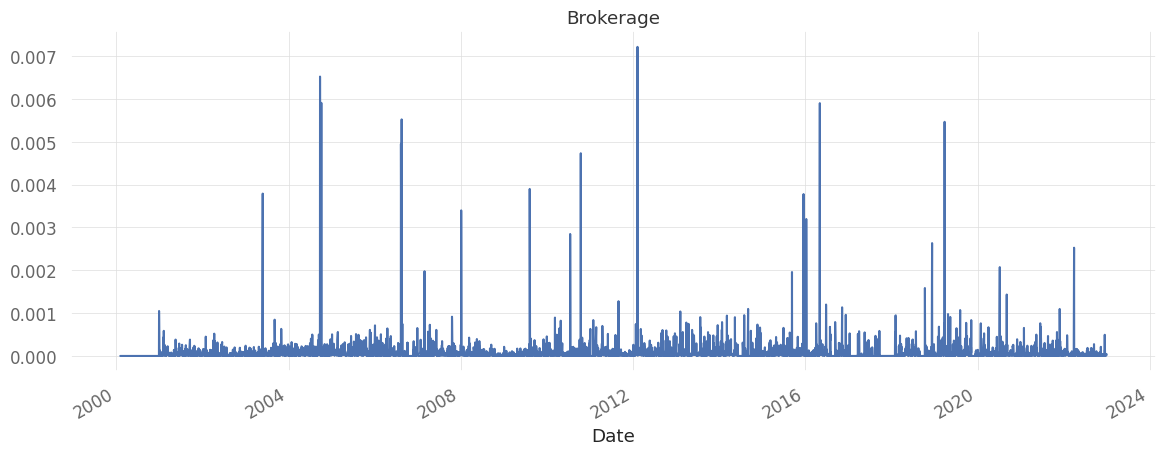

In [19]:
# Compute brokerage fees
brokerage_fees = 0.0020  # 20 basis points
brokerage = turnover * brokerage_fees

# Plot Brokerage
brokerage.plot(title='Brokerage', figsize=(14, 5))
plt.show()

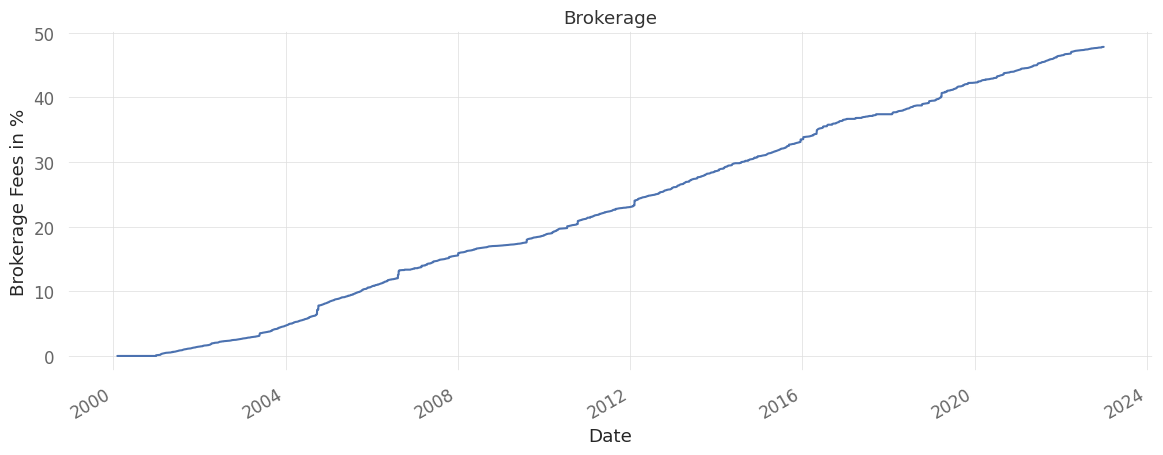

In [20]:
# Plot Cum Brokerage
(brokerage.cumsum()*100).plot(title='Brokerage', figsize=(14, 5))
plt.ylabel('Brokerage Fees in %')
plt.show()

#### Impact!
Wow! We pay almost 50% away to brokerage fees with only 20 basis points.

---

## Accounting for Bid-Ask Spread

Incorporating the bid-ask spread in backtesting is a nuanced decision, often contingent on the nature of the trading strategy. For vectorized backtesting, I usually ommit the bid-ask spread due to its relatively minor impact in this context. However, this element becomes significantly more relevant for intraday trading strategies, where even small fluctuations like bid-ask spreads can materially impact performance.

To effectively account for the bid-ask spread in such strategies, you need access to detailed market data, specifically the best bid and the best ask prices at the time of each transaction. This granularity allows for a more precise simulation of the costs you would encounter in actual trading scenarios.

In our context, we will use the average spread. Referring to a reliable online source such as ETF.com - reveals that the average bid-ask spread for an ETF like SPY (a popular S&P 500 ETF) is approximately 0.000032, which translates to 0.32 basis points. This figure, while seemingly small, can accumulate over numerous transactions, especially in high-frequency trading environments.

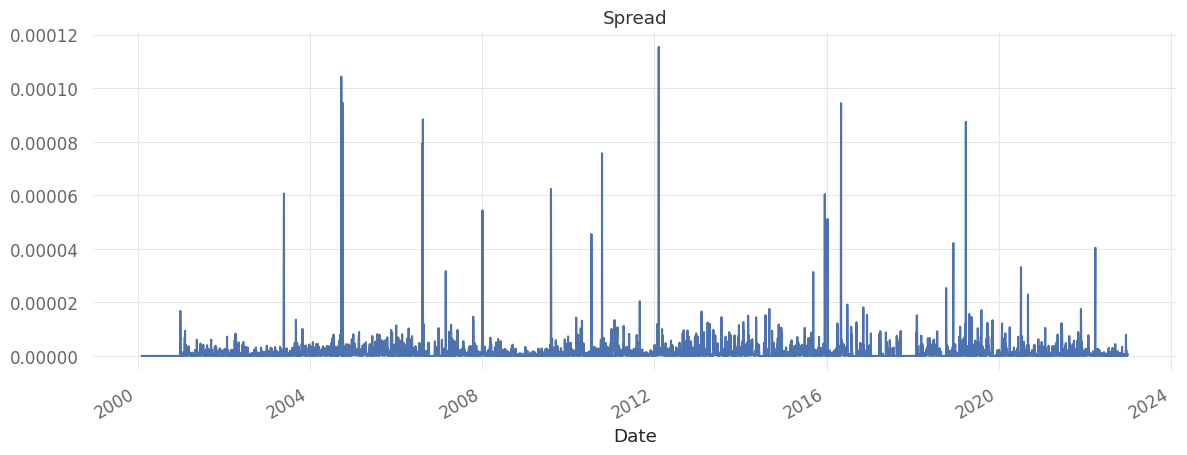

In [21]:
# Compute Spread fee
bid_ask_fee =0.000032  # 0.32 basis points
spread = turnover * bid_ask_fee

# Plot Brokerage
spread.plot(title='Spread', figsize=(14, 5))
plt.show()

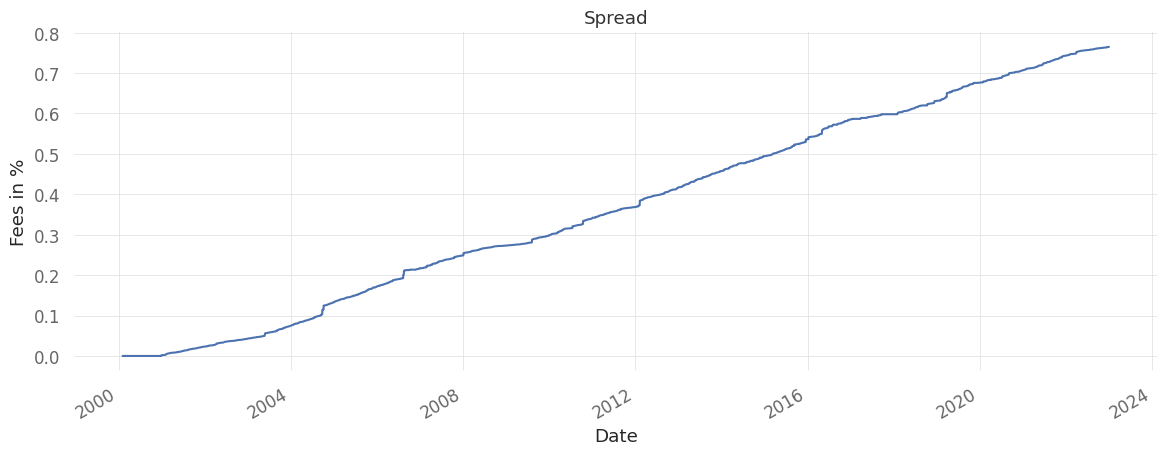

In [22]:
# Plot Cum Spread
(spread.cumsum()*100).plot(title='Spread', figsize=(14, 5))
plt.ylabel('Fees in %')
plt.show()

#### Impact ~
We pay about 0.8% fees over an almost 30 year period.

---
## Integrating Slippage (Market Impact)

Incorporating slippage, or market impact, in a vectorized backtest is a nuanced process. For simplicity and practicality, I typically use a fixed slippage value per trade. It's important to note, however, that in more sophisticated backtesting frameworks, such as event-driven systems or those using iterative loops, a dynamic approach to slippage is often more accurate. In these cases, the Linear Model is a common choice for estimating slippage.

### Understanding Slippage
Slippage represents the discrepancy between the expected price at which a trade is intended to be executed and the actual price at which it is executed. This difference can be significant, especially in fast-moving markets or when dealing with large orders.

### Key Points:
- **Simplified Approach:** In vectorized backtesting, due to its aggregate and simplified nature, using a fixed slippage value per trade can be a practical way to approximate market impact without overly complicating the model.
- **Event-Driven and Iterative Models:** These more detailed backtesting models allow for a more nuanced approach to slippage, accommodating varying market conditions and order sizes.

### Advanced Techniques:
- **Beyond the Scope:** While institutional-grade estimation techniques for slippage are available, they often involve complex mathematics and are beyond the scope of this course. However, we remain open to including such advanced content if there's enough student interest.
- **A Practical Guideline:** An accessible rule of thumb, as highlighted in the AI in Trading course from Udacity, suggests that "when a trade constitutes 1% of the Average Daily Volume, the price tends to shift by about 10 basis points." The transaction cost can then be estimated as the percent change in price multiplied by the amount traded.

This approach to integrating slippage in vectorized backtesting strikes a balance between realism and computational simplicity. It's important for students to understand the limitations of this method and recognize the potential for more complex, dynamic models in advanced trading scenarios. By incorporating even a simplified version of slippage, traders can achieve a more realistic assessment of their strategy's performance.

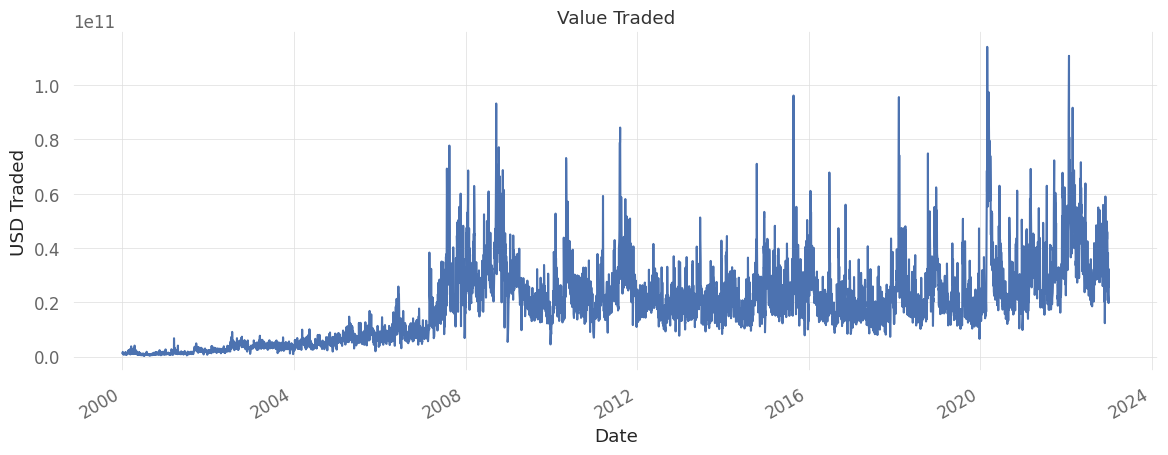

In [23]:
# Volume on SPY is massive, we are probably never going to be 1% of ADV
daily_value = volume * close_prices
daily_value.plot(title='Value Traded', figsize=(14, 5))
plt.ylabel('USD Traded')
plt.show()

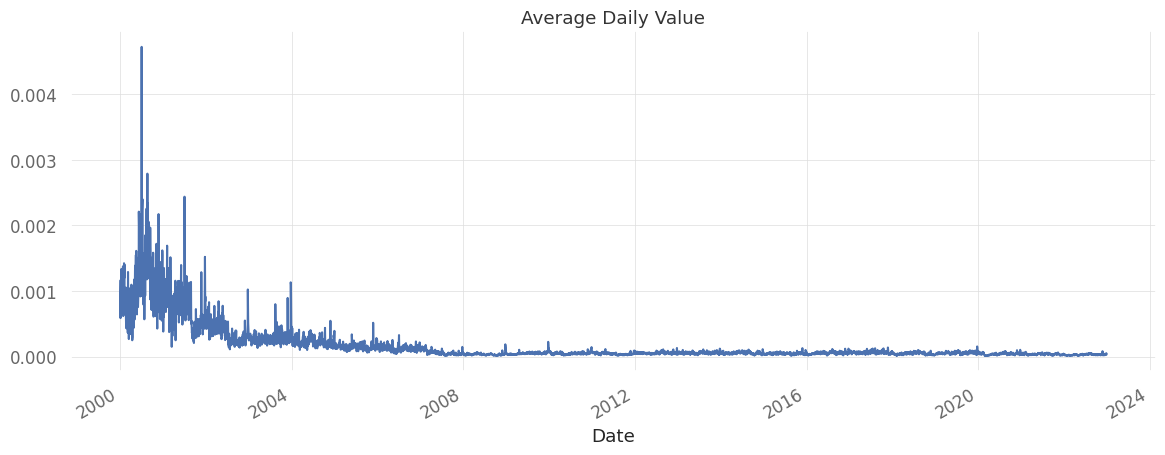

In [24]:
# Lets assume we are going to have a maximum of 1'000'000 USD traded on any day
# Therefor
adv = 1000000 / daily_value
adv.plot(title='Average Daily Value', figsize=(14, 5))
plt.show()

Here you can see, we never reach that value. 

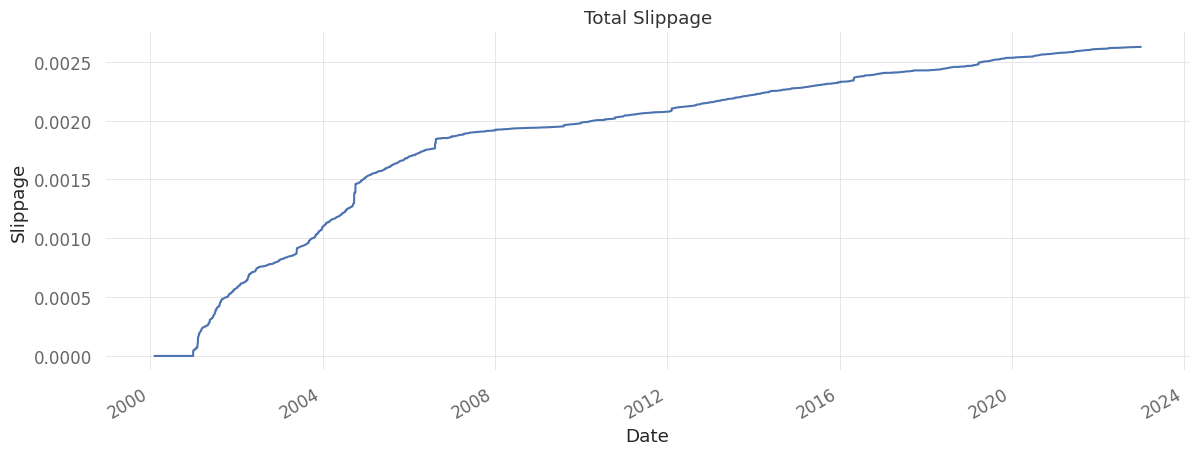

In [25]:
# Lets use this to compute slippage costs, linearly (This is not the Linear Model)
# If 1% = 10 basis points then every 10 basis points of ADV can be 1 basis point of slippage.
cost = (adv / 0.01) * 0.0010
slippage = cost * turnover

# Plot total slippage
slippage.cumsum().plot(title='Total Slippage', figsize=(14, 5))
plt.ylabel('Slippage')
plt.show()

**Notes:**

* **Total Slippage**: Is less than 25 basis points for the entire period, assuming a max $1 Million a day transaction.
* **Observing Initial High Costs:** You might notice that the transaction costs are considerably higher in the early stages. This is attributed to the Average Daily Volume (ADV) being substantially higher before 2004. As the index gains popularity and trading volume increases, these costs tend to decrease.
* **Approach to Slippage in Vectorized Backtesting:** While vectorized backtesting offers computational efficiency, it's generally advisable to omit detailed slippage calculations from this method. The reason is that vectorized backtesting lacks the granularity needed for accurately simulating slippage. Instead, slippage is more effectively computed within a for-loop or an event-driven backtesting framework, where a more precise model can be applied to each trade individually.
* **Impact of Liquidity on Slippage:** Be aware that slippage tends to be more pronounced in stocks with lower liquidity. In such cases, even relatively small orders can significantly impact the market price, leading to a larger gap between the expected and executed prices of trades. This factor is particularly important for strategies involving illiquid assets or large trade volumes relative to the asset's trading activity.

---
## Total Costs


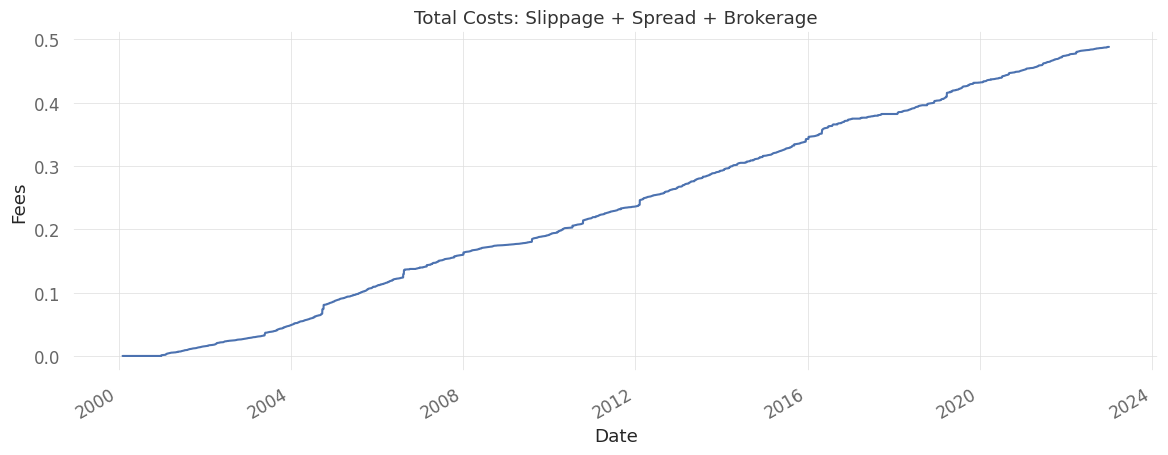

In [26]:
total_costs = slippage + spread + brokerage

# Plot total costs
total_costs.cumsum().plot(title='Total Costs: Slippage + Spread + Brokerage', figsize=(14, 5))
plt.ylabel('Fees')
plt.show()

## Before and After Costs

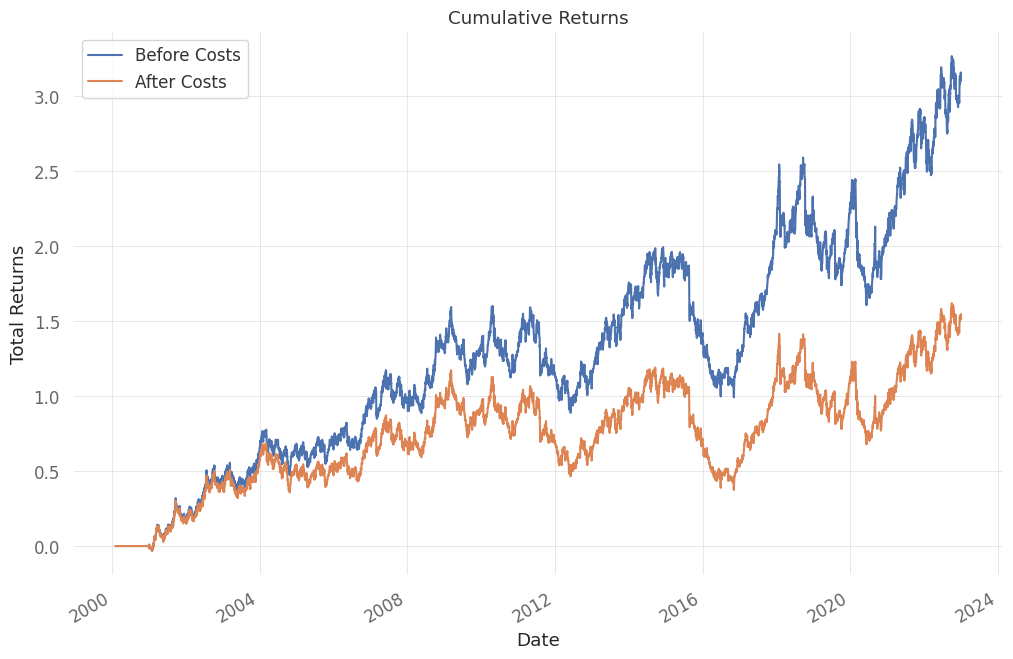

In [27]:
# Plot the cumulative rets (compounded growth)
# Before costs
((strategy_voltgt_returns + 1).cumprod()-1).plot()

# After Costs
after_cost = strategy_voltgt_returns - total_costs 
((after_cost + 1).cumprod()-1).plot(figsize = (12, 8))

# Plot Cum returns
plt.title('Cumulative Returns')
plt.legend(['Before Costs', 'After Costs'])
plt.ylabel('Total Returns')
plt.show()

In [28]:
sr_before = strategy_voltgt_returns.mean() / strategy_voltgt_returns.std() * np.sqrt(252)
sr_after = after_cost.mean() / after_cost.std() * np.sqrt(252)

print(f'Sharpe Ratio Before: {sr_before.round(2)}')
print(f'Sharpe Ratio After: {sr_after.round(2)}')

Sharpe Ratio Before: 0.47
Sharpe Ratio After: 0.33


**Notes:**
* Ouch! As you can see, these costs have lowered the sharpe ratio and hurt the total returns.
* You can always use QuantStats to plot a tearsheet for the two different performances.


---
### Conclusion
Accurately incorporating these transaction costs into backtesting models is essential for a realistic assessment of a strategy’s performance. Underestimating these costs can lead to an over-optimistic evaluation of a strategy, while overestimating them might unduly discard potentially profitable strategies. The key is to strike a balance, using historical data and realistic assumptions to closely mirror the conditions faced in actual trading.